In [1]:
import torch
import pandas as pd
import os.path as osp
import numpy as np
import itertools
from PIL import Image

from artemis.in_out.basics import unpickle_data, files_in_subdirs
from artemis.utils.vocabulary import Vocabulary
from artemis.in_out.neural_net_oriented import torch_load_model
from artemis.utils.visualization import visualize_attention_map_per_token
from artemis.evaluation_fixed.single_caption_per_image import apply_basic_evaluations

%load_ext autoreload
%autoreload 2

In [2]:
wiki_art_img_dir = '/media/data/databases/artemis/wikiart'
references_file = '/media/data/LuoTing/local/work_space/out/step_1/All_dataset/artemis_gt_references_grouped.pkl'
text2emo_path = '/media/data/LuoTing/local/work_space/neural_nets/txt_to_emotion/lstm_based/best_model.pt'
vocab_path = '/media/data/LuoTing/local/work_space/out/step_1/All_dataset/vocabulary.pkl'
sampled_captions_file = '/media/data/LuoTing/local/work_space/out/step_3/10-24-2022-17-00-11/scst/result.pkl'
cached_tokens='/media/data/LuoTing/local/work_space/out/step_1/All_dataset/artemis-idxs.p'
split = 'test' # or val, up to you!
gpu_id = 0
default_lcs_sample = [25000, 800]

In [3]:
gt_data = next(unpickle_data(references_file))

train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
print('Unique Training Utterances', len(unique_train_utters))

# now focus on the data (split) that you created captions for
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

device = torch.device("cuda:" + str(gpu_id))
txt2emo_clf = torch_load_model(text2emo_path, map_location=device)

txt2emo_vocab = Vocabulary.load(vocab_path)
print('vocab size', len(txt2emo_vocab))

Training Utterances 338777
Unique Training Utterances 338144
Images Captioned 7933
vocab size 14469


In [4]:
evaluation_methods = {'bleu', 'cider','ciderD','meteor', 'rouge', 'emo_alignment'}
print(evaluation_methods)

{'bleu', 'ciderD', 'cider', 'emo_alignment', 'meteor', 'rouge'}


In [5]:
def print_out_some_basic_stats(captions):
    """ Helper function -- to print basic statistics of sampled generations
    Input: captions dataframe with column names caption
    """
    print('Some basic statistics:')
    mean_length = captions.caption.apply(lambda x: len(x.split())).mean()
    print(f'average length of productions {mean_length:.4}')
    unique_productions = len(captions.caption.unique()) / len(captions)
    print(f'percent of distinct productions {unique_productions:.2}')
    maximizer = captions.caption.mode()
    print(f'Most common production "{maximizer.iloc[0]}"')
    n_max = sum(captions.caption == maximizer.iloc[0]) 
    print(f'Most common production appears {n_max} times -- {n_max/ len(captions):.2} frequency.')
    u_tokens = set()
    captions.caption.apply(lambda x: [u_tokens.add(i) for i in x.split()]);
    print(f'Number of distinct tokens {len(u_tokens)}')

In [6]:
next(unpickle_data(sampled_captions_file))

[[{'sampling_rule': 'beam',
   'temperature': 0.3,
   'beam_size': 5,
   'max_utterance_len': None,
   'drop_unk': True,
   'drop_bigrams': True},
         art_style                                           painting  \
  0        Baroque  adriaen-van-de-velde_frozen-canal-with-skaters...   
  1        Baroque  adriaen-van-de-venne_an-amorous-peasant-couple...   
  2        Baroque                       adriaen-van-ostade_inn-scene   
  3        Baroque  adriaen-van-ostade_interior-of-a-farmhouse-wit...   
  4        Baroque  adriaen-van-ostade_peasants-drinking-and-makin...   
  ..           ...                                                ...   
  276  Romanticism       francisco-goya_the-fall-or-the-accident-1787   
  277  Romanticism                francisco-goya_witches-sabbath-1789   
  278  Romanticism  john-constable_the-stour-valley-with-the-churc...   
  279  Romanticism              joseph-wright_vesuvius-from-posillipo   
  280    Symbolism  pierre-puvis-de-chavannes_chri

In [7]:
saved_samples = next(unpickle_data(sampled_captions_file))

for sampling_config_details, captions, attn in saved_samples:  # you might have sampled under several sampling configurations
    print('Sampling Config:', sampling_config_details)        
    
    print('\nSome Random Samples:')    
    rs = captions.sample(min(len(captions), 5))[['caption', 'grounding_emotion']]        
    for _, row in rs.iterrows():
        if row.grounding_emotion is not None:
            print(row.grounding_emotion.capitalize(), end=' --- ')
        print(row.caption)
    
    print()            
    print_out_some_basic_stats(captions)
    print()
    
    merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
    hypothesis = merged.caption
    references = merged.references_pre_vocab # i.e., use references that do not have <UNK>
    ref_emotions = merged.emotion

    metrics_eval = apply_basic_evaluations(hypothesis, references, ref_emotions, txt2emo_clf, txt2emo_vocab, cached_tokens,
                                           nltk_bleu=False, lcs_sample=default_lcs_sample,
                                           train_utterances=unique_train_utters,
                                           methods_to_do=evaluation_methods)

    print(pd.DataFrame(metrics_eval))
    print()

Sampling Config: {'sampling_rule': 'beam', 'temperature': 0.3, 'beam_size': 5, 'max_utterance_len': None, 'drop_unk': True, 'drop_bigrams': True}

Some Random Samples:
Contentment --- it looks like the woman looks like she is looking at the woman
Sadness --- it looks like the man looks like she looks like she like someone
Awe --- the look on the woman s face looks like the woman with her baby
Contentment --- the look on the woman looks like the woman with her baby
Awe --- it looks like the man looks like the angel looking at the dark

Some basic statistics:
average length of productions 13.36
percent of distinct productions 0.83
Most common production "it looks like the people look like they are waiting in the dark"
Most common production appears 11 times -- 0.039 frequency.
Number of distinct tokens 136

BLEU: done
COCO-based-metrics: done
EMO-ALIGN: done
                        metric      mean       std
0                       BLEU-0  0.486413  0.145312
1                       BLEU-

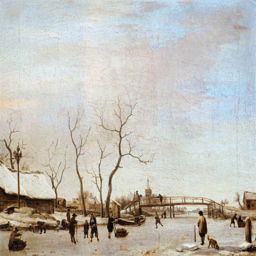

0 it looks like the people look like the people are walking over the town


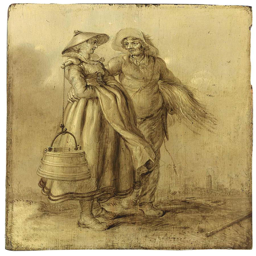

1 he look on the man s face looks like a dark and his body


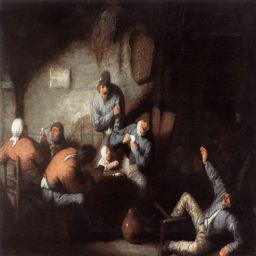

2 it looks like the woman is looking at the dog


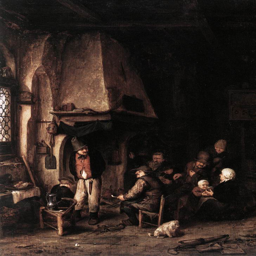

3 it looks like the woman looks like she is looking at the woman


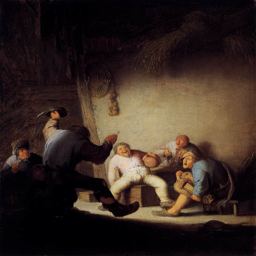

4 it looks like the man is looking at the woman


In [8]:
## Bonus see some Images with their caption.
max_results = 5
for i, row in captions.iterrows():
    if i >= max_results:
        break
    img_file = osp.join(wiki_art_img_dir, row['art_style'], row['painting'] + '.jpg')
    display(Image.open(img_file).resize((256, 256)))
    print(i, row['caption'])    

280


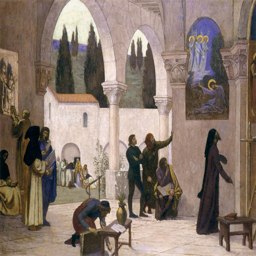

it looks like the man looks like the man looks like it is looking in the colors
new_im_size: [256, 256]


/media/data/LuoTing/local/work_space/artemis-master/artemis/utils/visualization.py:130: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



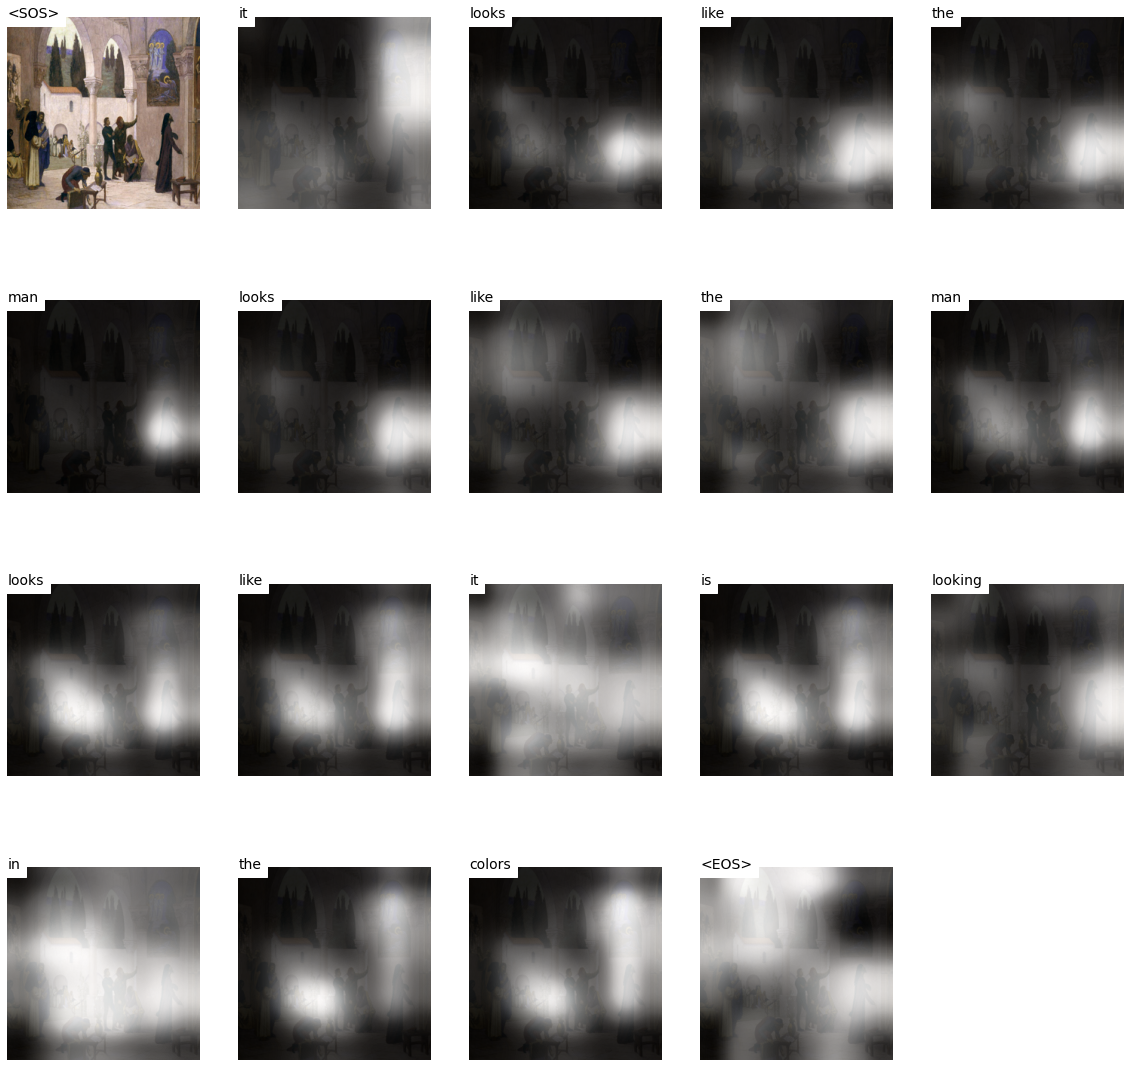

In [9]:
## Bonus see some attention Images.
random_id = 280 #np.random.randint(len(captions))
print(random_id)
row = captions.iloc[random_id]
img_file = osp.join(wiki_art_img_dir, row['art_style'], row['painting'] + '.jpg')
image = Image.open(img_file).resize((256, 256))
display(image)

print(row['caption'])

MAX_LEN = 30
pixel_upscale = 32

tokens = ['<SOS>'] + row['caption'].split() +  ['<EOS>']
tokens = tokens[:MAX_LEN]
attention_map = np.array(attn[random_id].cpu()).reshape(-1,8,8)
visualize_attention_map_per_token(image, tokens, attention_map, pixel_upscale, smooth_attention=True)





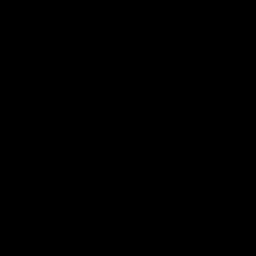

In [10]:
# 使用Image.new创建一个模式为'1'（黑白）的空白图片
img = Image.new('1', (256, 256), 0)
y = np.asarray(img)
img2 = Image.fromarray(y, mode='1')
img2

new_im_size: [256, 256]


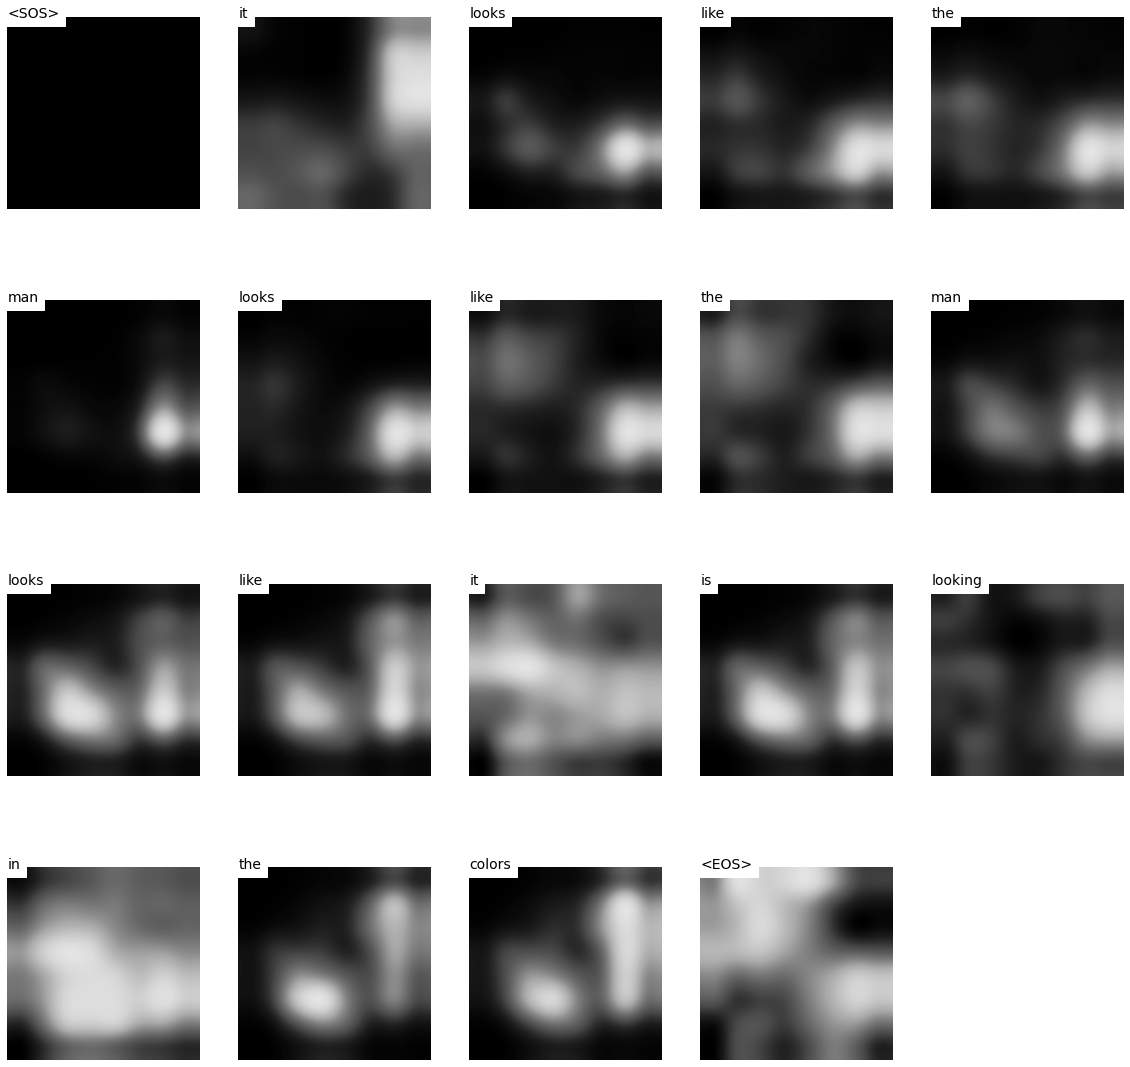

In [11]:
visualize_attention_map_per_token(img2, tokens, attention_map, pixel_upscale, smooth_attention=True)